In [1]:
import os
import re
import json
import codecs
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from sklearn.model_selection import train_test_split

In [2]:
if os.path.isdir('/srv/hd6/data'): # shad-gpu
    data_root_dir = '/srv/hd6/data/Poem2Poem/data'
    bpe_root_dir = '/srv/hd7/data/aklyopova'
elif os.path.isdir('/data'): # shad-almaren
    data_root_dir = 'data'
    bpe_root_dir = data_root_dir
else:
    assert False
assert os.path.isdir(data_root_dir)
assert os.path.isdir(bpe_root_dir)
    
amalgama_fname = data_root_dir + '/ParallelEnRu/Amalgama/amalgama-reversed-song-translations.jsonl'
subtitles_fname = data_root_dir + '/ParallelEnRu/OpenSubtitlesv2018/en-ru-reversed.jsonl'
bpe_dir_name = bpe_root_dir + '/translator_with_pentameter_16_03_2019'
SHAKESPEARE_SONNETS_PARALLEL_PATH = data_root_dir + \
'/Sonnets/ShakespeareSonnets/shakespeare-sonnets-en-ru-marshak.txt'

In [3]:
%%time

def get_amalgama_songs_subset(dataset_fname):
    songs = []
    errors = 0
    count = 0
    with codecs.open(dataset_fname,
                     mode = 'r',
                     encoding = 'utf-8') as f:
        for line in f:
            count += 1
            if count > 20000:
                break
            line = line.strip()
            if line == '':
                continue
            try:
                song = json.loads(line)
            except Exception as e:
                errors += 1
                print(e, '\n', line)
            songs.append([[line['texts'] \
                           for line in translation['lines'] \
                           if 'is_sub_caption' not in line \
                              and line['texts'] is not None] \
                          for translation in song['translations']])
    return songs, errors
    
songs, errors = get_amalgama_songs_subset(amalgama_fname)
train_songs, dev_songs = train_test_split(songs, test_size = 0.1, random_state = 1)
print('len(songs)', len(songs))
print('errors', errors)
print('len(train_songs)', len(train_songs))
print('len(dev_songs)', len(dev_songs))
print(train_songs[3])

len(songs) 20000
errors 0
len(train_songs) 18000
len(dev_songs) 2000
[[['niks ym gnihcuot ,deb ni gniyL', ',ежок йеовс к ьсюасакирп ,илетсоп в ажеЛ'], ["gnipeels t'nerew uoy hsiw I doG hO", '.ьшипс ыт отч ,ьлаж ,ежоБ'], ['niaga em ssik ot ,spil ruoy rof gnol I', ',яулецоп ялд мабуг миовт к ьсюажилбирп Я'], ["?gnihca s'ydob ym wonk uoy t'noD", '?тирог олет еом отч ,ьшеанз ен ыт евзаР'], [']ehtaerB[', ']еинахыД['], [',yap ot ecirp elttil a evah syawla ew smeeS', ',ьтиталп есв аз ынжлод адгесв ым ,ястежаК'], ["evol ni gnillaF m'I ,yap ot ecirP", ',ьсюялбюлв я - ,ьтиталП'], ['edaf ot strats ,strats lla tI', '...тен ан ьтидохс оннепетсоп теаничан есв ,теаничан есв адгот И'], ['syob elttil dab dna ,slrig daB', 'инрап еихолп и икночвед еихолП'], ["reverof tsal t'noW", ',адгесван етсемв тудуб ен адгокиН'], ['syob elttil doog dna ,slrig dooG tuB', 'инрап еишорох и икночвед еишорох оН'], ['rehtegot evol ekam lliW', '...агурд гурд ьтибюл тудуБ'], ['ekawa eil I sa ,ecaf ruoy ta kool I', ',юлпс ен 

In [4]:
%%time

def is_english(line):
    
    letters = re.sub(r'\W', '', line.lower())
    return len(letters) > 0 and \
           all([ord('a') <= ord(c) <= ord('z') for c in letters])


def get_lines_from_amalgama_songs(songs,
                                  possible_source_chars,
                                  possible_target_chars):
    lines_foreign = []
    lines_russian = []
    for song in songs:
        for translation in song:
            for line_pair in translation:
                if line_pair[0] is None or line_pair[1] is None:
                    continue
                if not is_english(line_pair[0]):
                    continue
                line_pair[0] = line_pair[0].lower()
                line_pair[1] = line_pair[1].lower()
                line_pair[0] = u''.join([c for c in line_pair[0] if \
                                         c in possible_source_chars])
                line_pair[1] = u''.join([c for c in line_pair[1] if \
                                         c in possible_target_chars])
                lines_foreign.append(line_pair[0])
                lines_russian.append(line_pair[1])
    return lines_foreign, lines_russian

ENGLISH_CHARS = set([chr(n) for n in range(ord('A'), ord('Z') + 1)] + \
                    [chr(n) for n in range(ord('a'), ord('z') + 1)] + [' ', '@', '-', "'"])
RUSSIAN_CHARS = set([chr(n) for n in range(ord('А'), ord('Я') + 1)] + \
                    [chr(n) for n in range(ord('а'), ord('я') + 1)] + [' ', '@', '-', 'Ё', 'ё'])
print('\nRUSSIAN_CHARS\n', RUSSIAN_CHARS, '\n')

(amalgama_train_lines_foreign,
 amalgama_train_lines_russian) = get_lines_from_amalgama_songs(train_songs,
                                                               ENGLISH_CHARS,
                                                               RUSSIAN_CHARS)
print('len(amalgama_train_lines_foreign)', len(amalgama_train_lines_foreign))
print('len(amalgama_train_lines_russian)', len(amalgama_train_lines_russian))
(amalgama_dev_lines_foreign,
 amalgama_dev_lines_russian) = get_lines_from_amalgama_songs(dev_songs,
                                                             ENGLISH_CHARS,
                                                             RUSSIAN_CHARS)
print('len(amalgama_dev_lines_foreign)', len(amalgama_dev_lines_foreign))
print('len(amalgama_dev_lines_russian)', len(amalgama_dev_lines_russian))


RUSSIAN_CHARS
 {'п', 'Т', 'ь', 'С', 'л', 'ю', 'в', 'Ъ', 'И', 'Г', 'Ь', 'А', 'к', 'Х', 'а', 'м', 'ф', 'х', 'Б', 'К', 'Н', 'Р', 'Л', 'М', 'Э', 'р', 'е', 'ъ', 'У', 'Ф', 'ц', ' ', 'ё', 'П', 'Ш', 'з', 'Й', 'э', 'ч', 'В', 'Ю', 'т', 'у', 'щ', 'я', 'й', 'Д', 'Ч', 'ы', 'Е', 'Ы', 'д', 'Щ', 'г', 'с', 'ж', 'ш', '@', 'О', 'и', 'Ё', 'б', 'о', '-', 'Ж', 'Я', 'н', 'Ц', 'З'} 

len(amalgama_train_lines_foreign) 705119
len(amalgama_train_lines_russian) 705119
len(amalgama_dev_lines_foreign) 79183
len(amalgama_dev_lines_russian) 79183
CPU times: user 14.3 s, sys: 108 ms, total: 14.4 s
Wall time: 14.5 s


In [5]:
print('\n'.join(amalgama_train_lines_foreign[:4]))
print()
print('\n'.join(amalgama_train_lines_russian[:4]))

ah ah ah ah ah aha
ah ah ah ah ah aha
niaga aes ot tuo og i ereh
riah ym sllif enihsnus eht

а-а-а-а-аха
а-а-а-а-аха
юром к уди авонс я тов и
ысолов мецнлос ытилаз


In [6]:
%%time
import os
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))


def def_get_BPE_dicts(train_lines_foreign, train_lines_russian):

    
    with codecs.open(os.path.join(bpe_dir_name, 'train_lines_foreign'),
                     mode = 'w',
                     encoding = 'utf-8') as f:
        f.write('\n'.join(map(tokenize, train_lines_foreign)))
    with codecs.open(os.path.join(bpe_dir_name, 'train_lines_russian'),
                     mode = 'w',
                     encoding = 'utf-8') as f:
        f.write('\n'.join(map(tokenize, train_lines_russian)))

    bpe = {}
    for lang in ['foreign', 'russian']:
        learn_bpe(codecs.open(os.path.join(bpe_dir_name,
                                           'train_lines_{}'.format(lang)),
                              mode = 'r',
                              encoding = 'utf-8'),
                  codecs.open(os.path.join(bpe_dir_name,
                                           'bpe_rules_{}_40000'.format(lang)),
                              mode = 'w',
                              encoding = 'utf-8'),
                  num_symbols = 40000)
        bpe[lang] = BPE(codecs.open(os.path.join(bpe_dir_name,
                                                 'bpe_rules_{}_40000'.format(lang)),
                                    mode = 'r',
                                    encoding = 'utf-8'))
    return bpe

bpe = def_get_BPE_dicts(amalgama_train_lines_foreign, amalgama_train_lines_russian)

CPU times: user 2min 18s, sys: 896 ms, total: 2min 19s
Wall time: 2min 18s


In [7]:
%%time

amalgama_train_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in amalgama_train_lines_foreign]
amalgama_dev_lines_foreign_bpe = \
[bpe['foreign'].process_line(line.strip()) for line in amalgama_dev_lines_foreign]

amalgama_train_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in amalgama_train_lines_russian]
amalgama_dev_lines_russian_bpe = \
[bpe['russian'].process_line(line.strip()) for line in amalgama_dev_lines_russian]

CPU times: user 25.6 s, sys: 116 ms, total: 25.7 s
Wall time: 25.7 s


In [8]:
%%time
train_inp = np.array([line[:150] for line in amalgama_train_lines_foreign_bpe])
train_out = np.array([line[:150] for line in amalgama_train_lines_russian_bpe])

CPU times: user 676 ms, sys: 412 ms, total: 1.09 s
Wall time: 1.1 s


In [9]:
dev_inp = np.array([line[:150] for line in amalgama_dev_lines_foreign_bpe])
dev_out = np.array([line[:150] for line in amalgama_dev_lines_russian_bpe])

In [10]:
# utils.py is copied from Homework 4 assignment as is
from utils import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)
# Here's how you cast lines into ids and backwards.
batch_lines = dev_inp[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print(type(batch_lines))
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)
print(type(batch_lines_restored))

lines
['hguorht swolb mrots eht sa hctaw' 'uoy deen i dna'
 'snwod dna spu eht rof uoy em evag dog esuac'
 'tbuod fo syad eht rof uoy em evag dog'
 "yaw ym tsol ev@@ '@@ i kniht i nehw rof dna"]
<class 'numpy.ndarray'>

words to ids (0 = bos, 1 = eos):
[[    0 12753 31222 16834  6051 25594 12603     1     1     1     1     1
      1]
 [    0 34882  2797 13227  4332     1     1     1     1     1     1     1
      1]
 [    0 29099  4332 29503  6051 25076 34882  7115  9820  4631  8884     1
      1]
 [    0 31523 10354 31260  6051 25076 34882  7115  9820  4631     1     1
      1]
 [    0 35661 36522 34210  9811     6 13227 14732 13227 17820 25076  4332
      1]]

back to words
['hguorht swolb mrots eht sa hctaw', 'uoy deen i dna', 'snwod dna spu eht rof uoy em evag dog esuac', 'tbuod fo syad eht rof uoy em evag dog', "yaw ym tsol ev@@ '@@ i kniht i nehw rof dna"]
<class 'list'>


In [11]:
del bpe

Sonnet generally consists of 14 lines but some of them more, like 15 in this Shakeapeare sonnet:

```
The forward violet thus did I chide,
Sweet thief, whence didst thou steal thy sweet that smells,
If not from my love’s breath? The purple pride
Which on thy soft check for complexion dwells,
In my love’s veins thou hast too grossly dyed.
The lily I condemned for thy hand,
And buds of marjoram had stol’n thy hair,
The roses fearfully on thorns did stand,
One blushing shame, another white despair:
A third nor red, nor white, had stol’n of both,
And to his robbery had annexed thy breath,
But for his theft in pride of all his growth
A vengeful canker eat him up to death.
More flowers I noted, yet I none could see,
But sweet, or colour it had stol’n from thee.```

We will drop such sonnets

In [12]:
def get_sonnets_lines_parallel(fname):
    sonnet_lines_english = []
    sonnet_lines_russian = []
    non_fourteen_lines = 0
    with codecs.open(fname, mode = 'r', encoding = 'utf-8') as f:
        sonnets = f.read().replace('\r', '').split('\n===\n')
    for sonnet in sonnets:
        en, ru = sonnet.split('\n---\n')
        en = [line.strip() for line in en.split('\n') if line.strip() != '']
        ru = [line.strip() for line in ru.split('\n') if line.strip() != '']
        if len(en) != 14 or len(ru) != 14:
            non_fourteen_lines += 1
            continue
        sonnet_lines_english.extend(en)
        sonnet_lines_russian.extend(ru)
    assert len(sonnet_lines_english) == len(sonnet_lines_russian)
    return sonnet_lines_english, sonnet_lines_russian, non_fourteen_lines

import re
def remove_punc_and_lower(line):
    line = re.sub(r'[^\w\s]', '', line)
    line = re.sub(r'\s+', ' ', line)
    return line.strip().lower()

(sonnet_lines_english,
 sonnet_lines_russian,
 non_fourteen_lines) = \
get_sonnets_lines_parallel(SHAKESPEARE_SONNETS_PARALLEL_PATH)
print('len(sonnet_lines_english)', len(sonnet_lines_english))
print('len(sonnet_lines_russian)', len(sonnet_lines_russian))
print('non_fourteen_lines', non_fourteen_lines)
print(sonnet_lines_english[100])
print(sonnet_lines_russian[100])
print(sonnet_lines_english[200])
print(sonnet_lines_russian[200])

(train_sonnet_lines_english,
 dev_sonnet_lines_english,
 train_sonnet_lines_russian,
 dev_sonnet_lines_russian) = train_test_split([remove_punc_and_lower(line) for \
                                               line in sonnet_lines_english],
                                              [remove_punc_and_lower(line) for \
                                               line in sonnet_lines_russian],
                                              test_size = 0.15,
                                              random_state = 1)
print('------------------')
print(train_sonnet_lines_russian[0])
print(dev_sonnet_lines_russian[0])

len(sonnet_lines_english) 2128
len(sonnet_lines_russian) 2128
non_fourteen_lines 2
Why lov’st thou that which thou receiv’st not gladly,
Зачем же любишь то, что так печально,
When I perceive that men as plants increase,
Что нас, как всходы нежные растений,
------------------
но вижу я в твоих глазах предвестье
уверенность и власть греховных сил


As one can see, some lines don't correspond to -+-+-+-+-+ pattern but correspond to -+-+-+-+-+-

Let us try to filter out non-10 syllables lines and see how much lines will remain

In [13]:
def count_syllables_russian(line):
    vowels = 'аеёиоуыэюяАЕЁИОУЫЭЮЯ'
    return len([c for c in line if c in vowels])

train_sonnet_lines_russian_ten_syllables = \
[line for line in train_sonnet_lines_russian if \
 count_syllables_russian(line) == 10]

dev_sonnet_lines_russian_ten_syllables = \
[line for line in dev_sonnet_lines_russian if \
 count_syllables_russian(line) == 10]

print(len(train_sonnet_lines_russian))
print(len(dev_sonnet_lines_russian))
print(len(train_sonnet_lines_russian_ten_syllables))
print(len(dev_sonnet_lines_russian_ten_syllables))

1808
320
1184
194


Too little lines remain if we filter them by syllables count thus let us not filter them

In [14]:
train_sonnet_lines_russian_stresses = \
[[i % 2 == 1 for i in range(count_syllables_russian(line))] \
 for line in train_sonnet_lines_russian]
dev_sonnet_lines_russian_stresses = \
[[i % 2 == 1 for i in range(count_syllables_russian(line))] \
 for line in dev_sonnet_lines_russian]

In [15]:
%env CUDA_VISIBLE_DEVICES=5
import tensorflow as tf
import keras.layers as L
from keras import backend as K
from utils import infer_length, infer_mask

env: CUDA_VISIBLE_DEVICES=5


Using TensorFlow backend.


In [16]:
class ITranslationModel(object):

    def make_initial_state(self, lines):
        '''
        Accepts array of lines.
        Returns initial translation state for lines.
        '''
        raise Exception('Not implemented')
    
    def get_next_state_and_logits(self, state, outputs):
        '''
        Accepts current translation state and model outputs.
        Returns next translation state and logits.
        '''
        raise Exception('Not implemented')
    
    def get_output_vocabulary(self):
        '''
        Return output vocabulary used in model.
        '''
        raise Exception('Not implemented')


In [17]:
class CharVocab(Vocab):
    def __init__(self, chars, unk = '?'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert unk not in chars
        Vocab.__init__(self, tokens = chars + ['_BOS_', '_EOS_', unk], unk = unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [ch if ch in self.token_to_ix else self.unk
                  for ch in string]
        return [self.bos] + tokens + [self.eos]
    
    def tokenize_to_ids(self, string):
        
        token_ids = [self.token_to_ix.get(ch, self.unk_ix) for ch in string]
        return [self.bos_ix] + token_ids + [self.eos_ix]

    def to_lines(self, matrix, crop=True):
        # input: matrix is numpy array of shape (n_lines, >=max_doc_len_in_char_tokens)
        # return: list of string lines
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ''.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

    def tok_matrix_to_char_matrix(self, tok_voc, tok_matrix, max_tok_len = 10):
        # input: tok_matrix is numpy array of shape (n_lines, >=max_doc_len_in_bpe_tokens)
        # input example for tok_voc.tokens = {101: 'a', 102: 'abc', 103: 'ca', ...}:
        # [[101, 102]
        #  [103, <eos>]]
        # output_example for self.tokens = {1: 'a', 2: 'b', 3: 'c', ...}:
        # [[[1, <eos>, <eos>], [1, 2, 3]]
        #  [[3, 1, , <eos>], [<eos>, <eos>, <eos>]]]
        assert tok_matrix.ndim == 2
        
        get_tok_str = lambda tok: tok_voc.tokens[tok].replace('@@', '@') if tok != tok_voc.eos_ix else ''
        
        max_len = max_tok_len or \
                  (max(map(lambda tok: len(get_tok_str(tok)), tok_matrix.flatten())) + 2)
        assert max_len >= 2
        
        matrix = np.full(tok_matrix.shape + (max_len,),
                         fill_value = self.eos_ix,
                         dtype = np.int32)
        
        for i, tok_seq in enumerate(tok_matrix):
            for j, tok in enumerate(tok_seq):
                tok_str = get_tok_str(tok)[:max_len - 2]
                matrix[i, j, :len(tok_str) + 2] = self.tokenize_to_ids(tok_str)

        return matrix

In [18]:
def get_type_full_name(t):
    assert isinstance(t, type)
    res = t.__qualname__
    if t.__module__ not in ('builtins', '__main__'):
        res = t.__module__ + '.' + res
    return res

class ConfigBase(object):

    def __init__(self, cfg, user_args, **kwargs):
        # We need this class to avoid passing
        # too many params in model classes initializers
        # Example usage:
        #    class MyConfig(ConfigBase):
        #        def __init__(self, **kwargs):
        #            super().__init__(self,
        #                             user_args = kwargs,
        #                             emb_size = None,
        #                             hid_size = None,
        #                             dropout_prob = None)
        #
        #    my_config = MyConfig(emb_size = 150,
        #                         hid_size = 50,
        #                         dropout_prob = 0)
        
        for key, user_val in user_args.items():
            assert key in kwargs, 'Unknown field "{}" with value "{}"'.format(key, user_val)
            assert user_val is not None, 'Field "{}" can\'t have "None" value'.format(key)
            
            default_val = kwargs[key]
            is_subconfig = isinstance(default_val, type) and issubclass(default_val, ConfigBase)
            
            if isinstance(user_val, ConfigBase):
                assert is_subconfig, \
                       'Field "{}" is not a sub-config and can\'t be set with config "{}"' \
                       .format(key, get_type_full_name(type(user_val)))
                assert type(user_val) == default_val, \
                       'Sub-config "{}" must have type "{}", instead "{}" given' \
                       .format(key, get_type_full_name(default_val), get_type_full_name(type(user_val)))
            elif is_subconfig:
                assert isinstance(user_val, dict), \
                       'Sub-config "{}" of type "{}" can only be created from dict, not "{}" of type "{}"' \
                       .format(key, get_type_full_name(default_val), user_val, get_type_full_name(type(user_val)))
                user_val = default_val(**user_val)
            
            kwargs[key] = user_val
            
        for key, user_val in kwargs.items():
            assert user_val is not None, 'Field "{}" without default value is not set'.format(key)
            setattr(cfg, key, user_val)
        
        self._keys = list(kwargs.keys())
    
    def as_dict(self):
        res = {key: getattr(self, key) for key in self._keys}
        for key in self._keys:
            if isinstance(res[key], ConfigBase):
                res[key] = res[key].as_dict()
        return res

In [19]:
def get_scope_trainable_variables(sub_scope_name = None):
    full_scope_name = tf.get_variable_scope().name
    if full_scope_name != '':
        full_scope_name += '/'
    if sub_scope_name is not None:
        full_scope_name += sub_scope_name + '/'
    return tf.trainable_variables(scope = re.escape(full_scope_name))

In [20]:
import pickle
import numpy as np
import tensorflow as tf
import keras.layers as L
from keras import backend as K
from utils import infer_length, infer_mask


class AttentionLayer:
    
    def __init__(self, name, hid_size, activ=tf.tanh):
        """ A layer that computes additive attention response and weights """
        self.name = name
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        with tf.variable_scope(name):
            # YOUR CODE - create layer variables
            #<YOUR CODE>
            self.linear_e = L.Dense(hid_size)
            self.linear_d = L.Dense(hid_size)
            self.linear_out = L.Dense(1)

    def __call__(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        with tf.variable_scope(self.name):
            
            # Compute logits
            #<...>
            logits_seq = self.linear_out(self.activ(self.linear_e(enc) + \
                                                    self.linear_d(dec)[:, tf.newaxis, :]))
            logits_seq = tf.squeeze(logits_seq, axis = -1)
            
            # Apply mask - if mask is 0, logits should be -inf or -1e9
            # You may need tf.where
            #<...>
            
            logits_seq = tf.where(inp_mask, logits_seq, tf.fill(tf.shape(logits_seq),
                                                                -np.inf))
            
            # Compute attention probabilities (softmax)
            probs = tf.nn.softmax(logits_seq) # <...>
            
            # Compute attention response using enc and probs
            attn = tf.reduce_sum(probs[..., tf.newaxis] * enc, axis = 1) # <...>
            
            return attn, probs

In [21]:
class RuCharEncoder:
    # This class is needed to create chr representation,
    # which is, like in DeepSpeare,
    # shareable between translator and meter models
    
    class Config(ConfigBase):
        def __init__(self, **kwargs):
            super().__init__(self,
                             kwargs,
                             emb_size = None,
                             hid_size = None,
                             dropout_prob = None)
    
    deepspeare_en_config = Config(emb_size = 150,  # as 'char_embedding_dim'
                                  hid_size = 50,   # as 'pm_enc_dim'
                                  #dropout_prob = 1 - 0.7) # as 'keep_prob'
                                  dropout_prob = 0) # to show proper BLEU
    
    def __init__(self, name, config, is_training):
        # ToDo: deal with 'is_training'
        
        assert type(name) == str
        assert type(config) == RuCharEncoder.Config

        self.name = name
        self.config = config
        
        ru_vowels = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я']
        ru_other_letters = [chr(n) for n in range(ord('а'), ord('я') + 1) if chr(n) not in ru_vowels]
        vocab = CharVocab(chars = ru_vowels + ru_other_letters + [' ', '@'])
        self.space_idx = vocab.token_to_ix[' ']
        self.tok_concat_idx = vocab.token_to_ix['@']
        self._vowel_max_idx = len(ru_vowels) - 1
        self._ru_char_voc = vocab
        
        with tf.variable_scope(name):
            
            self._inp = tf.placeholder(tf.int32, [None, None])
            
            self._emb_inp = L.Embedding(len(self._ru_char_voc), config.emb_size)
            
            # In original DeepSpeare code they use the same LSTM Cell
            # for both directions
            # Maybe it's better to use two separate cells:
            #self._enc_lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(config.hid_size)
            #self._enc_lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(config.hid_size)
            
            enc_cell = tf.nn.rnn_cell.LSTMCell(config.hid_size)
            if is_training and config.dropout_prob > 0:
                enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob = 1 - config.dropout_prob)
                
            self._enc_lstm_fw_cell = enc_cell
            self._enc_lstm_bw_cell = enc_cell
            
            self._enc_seq, self._en_last_hid = self.encode(self._inp)
            
            self.trainable_variables = get_scope_trainable_variables()

    def lines_to_char_matrix(self, lines, max_len = 100):
        return self._ru_char_voc.to_matrix(lines, max_len)
            
    def tok_matrix_to_char_matrix(self, tok_voc, tok_matrix, max_tok_len = 10):
        return self._ru_char_voc.tok_matrix_to_char_matrix(tok_voc, tok_matrix, max_tok_len)
            
    def vowel_mask(self, inp):
        return inp <= self._vowel_max_idx
    
    def make_input_feed_dict(self, inp_lines):
        return { self._inp: self._ru_char_voc.to_matrix(inp_lines) }
    
    def get_input(self):
        return self._inp
    
    def get_eos_ix(self):
        return self._ru_char_voc.eos_ix
    
    def get_encoded_seq(self):
        return self._enc_seq
    
    def get_encoded_last_hid(self):
        return self._en_last_hid
    
    def encode(self, inp):
        '''
        Return tuple:
        res[0]: encode seq, float32[batch_size, max_time, cfg.hid_size * 2]
        res[1]: encode last hidden state, float32[batch_size, cfg.hid_size * 2]
        '''
        assert inp.shape.ndims == 2 # [batch_size, max_time]
        
        inp_lengths = infer_length(inp, self._ru_char_voc.eos_ix)
        
        inp_emb = self._emb_inp(inp)
        with tf.variable_scope('enc'):
            ((enc_seq_fw,
              enc_seq_bw),
             (enc_last_fw,
              enc_last_bw)) = tf.nn.bidirectional_dynamic_rnn(self._enc_lstm_fw_cell,
                                                              self._enc_lstm_bw_cell,
                                                              inp_emb,
                                                              sequence_length = inp_lengths,
                                                              dtype = inp_emb.dtype)
        enc_seq = tf.concat((enc_seq_fw, enc_seq_bw), axis = -1)
        enc_last_hid = tf.concat((enc_last_fw[1], enc_last_bw[1]), axis = -1)
        return enc_seq, enc_last_hid

In [22]:
def infer_length_exclude_eos(seq, eos_ix, dtype=tf.int32):
    is_eos = tf.cast(tf.equal(seq, eos_ix), dtype)
    count_eos = tf.cumsum(is_eos,axis=1,exclusive=False)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos,0),dtype),axis=1)
    return lengths

class MeterModel:
    # Neural architecture of meter model
    # and most of code
    # are borrowed from DeepSpeare Pentameter model

    class Config(ConfigBase):
        def __init__(self, **kwargs):
            super().__init__(self,
                             kwargs,
                             max_out_length = None,
                             # From deepspeare code:
                             dropout_prob = None,
                             pm_dec_dim = None,
                             max_grad_norm = None,
                             pm_learning_rate = None,
                             pm_attend_dim = None,
                             sigma = None,
                             cov_loss_threshold = None,
                             repeat_loss_scale = None,
                             cov_loss_scale = None)
            
    deepspeare_config = Config(max_out_length = 15,
                               # From deepspeare code:
                               #dropout_prob = 1 - 0.7, # as 'keep_prob'
                               dropout_prob = 0, # to show proper BLEU
                               pm_dec_dim=200,
                               pm_attend_dim=50,
                               pm_learning_rate=0.001,
                               repeat_loss_scale=1.0,
                               cov_loss_scale=1.0,
                               cov_loss_threshold=0.7,
                               sigma=1.00,
                               max_grad_norm=5)
    
    def __init__(self, name, config, batch_size, is_training, ru_char_encoder):
        
        assert type(name) == str
        assert type(config) == MeterModel.Config

        self.name = name
        self.config = config

        self._ru_char_encoder = ru_char_encoder
        self._stress_eos_ix = -1

        cfg = self.config
        cfg_pm_enc_dim = ru_char_encoder.config.hid_size

        with tf.variable_scope(name):
            
            self._out = tf.placeholder(tf.int32, [None, None])

            dec_cell = tf.nn.rnn_cell.LSTMCell(cfg.pm_dec_dim)
            #if is_training and cfg.dropout_prob > 0:
            #    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob = 1 - cfg.dropout_prob)

            enc_hiddens = ru_char_encoder.get_encoded_seq()
            enc_hiddens  = tf.reshape(enc_hiddens, [-1, cfg_pm_enc_dim*2]) #[batch_size*num_steps, hidden]
                    
            #if not is_training:
            self.pm_costs     = self.compute_pm_loss(batch_size = batch_size,
                                                     enc_hiddens = enc_hiddens,
                                                     dec_cell = dec_cell)
            self.pm_mean_cost = tf.reduce_sum(self.pm_costs) / batch_size
            
            self.trainable_variables = get_scope_trainable_variables() + \
                                       ru_char_encoder.trainable_variables

        if is_training:
            #run optimiser and backpropagate (clipped) gradients for pm loss
            pm_tvars         = self.trainable_variables
            pm_grads, _      = tf.clip_by_global_norm(tf.gradients(self.pm_mean_cost, pm_tvars),
                                                      cfg.max_grad_norm)
            self.pm_train_op = tf.train.AdamOptimizer(cfg.pm_learning_rate).apply_gradients(zip(pm_grads, pm_tvars))
    
    def get_input(self):
        return self._ru_char_encoder.get_input()
    
    def get_output(self):
        return self._out
    
    def to_stress_matrix(self, stress_lines):
        
        max_len = min(self.config.max_out_length, max(map(len, stress_lines)))

        matrix = np.full((len(stress_lines), max_len), fill_value = self._stress_eos_ix, dtype = np.int32)
        for i, stresses in enumerate(stress_lines):
            stresses = stresses[:max_len]
            matrix[i, :len(stresses)] = stresses

        return matrix

    # -- compute pentameter model loss, given a pentameter input
    # It may seem strange that we pass dec_cell here despite it is 
    def compute_pm_loss(self, batch_size, enc_hiddens, dec_cell):
        
        # Note: Deepspeare uses old TensorFlow API where tf.concat accepts axis first like: tf.concat(1, [t1, t2])
        # So, here it is changed to new TF style: tf.concat([t1, t2], axis = 1)

        cfg = self.config
        cfg_pm_enc_dim = self._ru_char_encoder.config.hid_size

        space_id = self._ru_char_encoder.space_idx

        inp = self.get_input()
        out = self.get_output()
        out_len = infer_length_exclude_eos(out, self._stress_eos_ix)
        max_out_len = tf.shape(out)[1]

        eos_ix = self._ru_char_encoder.get_eos_ix()
        inp_lengths = infer_length(inp, eos_ix)
        inp_mask = infer_mask(inp, eos_ix, dtype = tf.bool)
        pm_cov_mask = tf.cast(self._ru_char_encoder.vowel_mask(inp) & inp_mask, dtype = tf.float32)
        #xlen_max       = tf.reduce_max(inp_lengths) # Logic in Deepspeare
        xlen_max       = tf.shape(inp)[1] # Our current logic

        #use decoder hidden states to select encoder hidden states to predict stress for next time step
        repeat_loss    = tf.zeros([batch_size])
        attentions     = tf.zeros([batch_size, xlen_max]) #historical attention weights
        prev_miu       = tf.zeros([batch_size,1])
        outputs        = []
        attention_list = []
        miu_list       = []

        #initial inputs (learnable) and state
        initial_inputs = tf.get_variable("dec_init_input", [cfg_pm_enc_dim*2])
        inputs         = tf.reshape(tf.tile(initial_inputs, [batch_size]), [batch_size, -1])
        state          = dec_cell.zero_state(batch_size, tf.float32)

        #manual unroll of time steps because attention depends on previous attention weights
        with tf.variable_scope("RNN"):
            for time_step in range(cfg.max_out_length):

                if time_step > 0:
                    tf.get_variable_scope().reuse_variables()

                def attend(enc_hiddens, dec_hidden, attn_hist, prev_miu):
                    with tf.variable_scope("pm_attention"):
                        attend_w = tf.get_variable("attend_w", [cfg_pm_enc_dim*2+cfg.pm_dec_dim, cfg.pm_attend_dim])
                        attend_b = tf.get_variable("attend_b", [cfg.pm_attend_dim], initializer=tf.constant_initializer())
                        attend_v = tf.get_variable("attend_v", [cfg.pm_attend_dim, 1])
                        miu_w    = tf.get_variable("miu_w", [cfg.pm_dec_dim+1, cfg.pm_attend_dim])
                        miu_b    = tf.get_variable("miu_b", [cfg.pm_attend_dim], initializer=tf.constant_initializer())
                        miu_v    = tf.get_variable("miu_v", [cfg.pm_attend_dim, 1])

                    #position attention
                    miu     = tf.minimum(tf.sigmoid(tf.matmul(tf.tanh(tf.matmul(tf.concat(
                        [dec_hidden, prev_miu], axis = 1), miu_w) + miu_b), miu_v)) + prev_miu, tf.ones([batch_size, 1]))
                    miu_p   = miu * tf.reshape(tf.cast(inp_lengths-1, tf.float32), [-1, 1])
                    pos     = tf.cast(tf.reshape(tf.tile(tf.range(xlen_max), [batch_size]), [batch_size, -1]),
                        dtype=tf.float32)
                    pos_lp  = -(pos - miu_p)**2 / (2 * tf.reshape(tf.tile([tf.square(cfg.sigma)], [batch_size]),
                        [batch_size,-1]))

                    #char encoding attention
                    pos_weight = tf.reshape(tf.exp(pos_lp), [-1, 1])
                    inp_concat = tf.concat([enc_hiddens * pos_weight,
                        tf.reshape(tf.tile(dec_hidden, [1,xlen_max]), [-1,cfg.pm_dec_dim])], axis = 1)
                    x       = inp
                    e       = tf.matmul(tf.tanh(tf.matmul(inp_concat, attend_w) + attend_b), attend_v)
                    e       = tf.reshape(e, [batch_size, xlen_max])
                    mask1   = tf.cast(~inp_mask, dtype=tf.float32)
                    mask2   = tf.cast(tf.equal(x, tf.fill(tf.shape(x), space_id)), dtype=tf.float32)
                    e_mask  = tf.maximum(mask1, mask2)
                    e_mask *= tf.constant(-1e20)

                    #combine alpha with position probability
                    alpha   = tf.nn.softmax(e + e_mask + pos_lp)
                    #alpha   = tf.nn.softmax(e + e_mask)

                    #weighted sum
                    c       = tf.reduce_sum(tf.expand_dims(alpha, 2)*tf.reshape(enc_hiddens,
                        [batch_size, xlen_max, cfg_pm_enc_dim*2]), 1)

                    return c, alpha, miu

                dec_hidden, state               = dec_cell(inputs, state)
                enc_hiddens_sum, attn, prev_miu = attend(enc_hiddens, dec_hidden, attentions, prev_miu)

                # Zero 'attn' if past end of output:
                valid_step = time_step < out_len
                attn *= tf.cast(valid_step, tf.float32)[:, tf.newaxis]
                
                repeat_loss += tf.reduce_sum(tf.minimum(attentions, attn), 1)
                attentions  += attn
                inputs       = enc_hiddens_sum

                attention_list.append(attn)
                miu_list.append(prev_miu)
                outputs.append(enc_hiddens_sum)

        #reshape output into [batch_size*num_steps,hidden_size]
        #outputs = tf.reshape(tf.concat(outputs, axis = 1), [-1, cfg_pm_enc_dim*2]) # Original code
        outputs = tf.concat(outputs, axis = 1)
        outputs = outputs[:, :max_out_len * cfg_pm_enc_dim*2] # Also truncate outputs
        outputs = tf.reshape(outputs, [-1, cfg_pm_enc_dim*2])
        

        #compute loss
        pm_softmax_w = tf.get_variable("pm_softmax_w", [cfg_pm_enc_dim*2, 1])
        pm_softmax_b = tf.get_variable("pm_softmax_b", [1], initializer=tf.constant_initializer())
        pm_logit     = tf.squeeze(tf.matmul(outputs, pm_softmax_w) + pm_softmax_b)
        pm_crossent  = tf.nn.sigmoid_cross_entropy_with_logits(logits = pm_logit,
            #labels = tf.tile(tf.cast(fixed_out, tf.float32), [batch_size])) # Original code
            labels = tf.reshape(tf.cast(out, tf.float32), [-1]))
        cov_loss     = tf.reduce_sum(tf.nn.relu(pm_cov_mask*cfg.cov_loss_threshold - attentions), 1)
        pm_cost      = tf.reduce_sum(tf.reshape(pm_crossent, [batch_size, -1]), 1) + \
            cfg.repeat_loss_scale*repeat_loss + cfg.cov_loss_scale*cov_loss

        #save some variables
        self.pm_logits     = tf.sigmoid(tf.reshape(pm_logit, [batch_size, -1]))
        self.pm_attentions = attention_list
        self.mius          = miu_list

        return pm_cost


In [23]:
class AttentiveModel(ITranslationModel):
    
    class Config(ConfigBase):
        def __init__(self, **kwargs):
            super().__init__(self,
                             kwargs,
                             batch_size = None,
                             emb_size = None,
                             hid_size = None,
                             #attn_size = None,
                             ru_char_encoder_config = RuCharEncoder.Config,
                             meter_config = MeterModel.Config)
    
    def __init__(self, sess, filename, name = None, inp_voc = None, out_voc = None, config = None):
        
        self.sess = sess
        
        if filename is None:
            self.initialize(name, inp_voc, out_voc, config)
        else:
            self.load(filename)
    
    
    def initialize(self, name, inp_voc, out_voc, config):
        
        assert type(config) == AttentiveModel.Config
        
        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc
        self.config = config
        cfg = config

        with tf.variable_scope(name):
            
            # YOUR CODE - define model layers
            
            # <...>
            self.emb_inp = L.Embedding(len(inp_voc), cfg.emb_size)
            self.emb_out = L.Embedding(len(out_voc), cfg.emb_size)
            self.enc_lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(cfg.hid_size)
            self.enc_lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(cfg.hid_size)
            #self.enc0 = tf.nn.rnn_cell.GRUCell(cfg.hid_size)

            self.dec_start = L.Dense(cfg.hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(cfg.hid_size)
            self.dense = L.Dense(cfg.hid_size)
            self.activ = tf.tanh
            self.logits = L.Dense(len(out_voc))
            
            self.attention = AttentionLayer(name = 'attention',
                                            hid_size = 2 * cfg.hid_size)
            
            self._ru_char_encoder = RuCharEncoder(name = 'ru_char_encoder',
                                                  config = cfg.ru_char_encoder_config,
                                                  is_training = True)
            
            self.meter_model = MeterModel(name = 'meter',
                                          config = cfg.meter_config,
                                          batch_size = cfg.batch_size,
                                          is_training = True,
                                          ru_char_encoder = self._ru_char_encoder)
            
            # END OF YOUR CODE
            
            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.prev_char_tokens = tf.placeholder('int32', [None, None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens, self.prev_char_tokens)
            self.next_softmax = tf.nn.softmax(self.next_logits)

            self.trainable_variables = get_scope_trainable_variables()
        
        # Call to 'K.get_session()' runs variable initializes for
        # all variables including ones initialized using
        # 'tf.global_variables_initializer()' (at least for Keras
        # 2.0.5) thus it have to be called once here or model weights
        # will be rewritten after training e.g. when 'get_weights' is
        # called.
        K.get_session()
    
    def to_out_char_matrix(self, out_tok_matrix, max_tok_len = 10):
        return self._ru_char_encoder.tok_matrix_to_char_matrix(self.out_voc, out_tok_matrix, max_tok_len)
    
    def to_meter_inp_char_matrix(self, inp_lines, max_len = 100):
        return self._ru_char_encoder.lines_to_char_matrix(inp_lines, max_len)
    
    def to_meter_out_stress_matrix(self, stress_lines):
        return self.meter_model.to_stress_matrix(stress_lines)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        # <YOUR CODE>
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_mask = infer_mask(inp, self.inp_voc.eos_ix, dtype = tf.bool)
        
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            #enc_seq, enc_last = tf.nn.dynamic_rnn(self.enc0,
            #                                      inp_emb,
            #                                      sequence_length = inp_lengths,
            #                                      dtype = inp_emb.dtype)
            ((enc_seq_fw,
              enc_seq_bw),
             ((enc_last_fw_cell_state,
               enc_last_fw_hid_state),
              enc_last_bw_state_tuple)) = tf.nn.bidirectional_dynamic_rnn(self.enc_lstm_fw_cell,
                                                                          self.enc_lstm_bw_cell,
                                                                          inp_emb,
                                                                          sequence_length = inp_lengths,
                                                                          dtype = inp_emb.dtype)
        enc_seq = tf.concat((enc_seq_fw, enc_seq_bw), axis = -1)
        # TODO: Don't feed cell LSTM state to decoder
        enc_last_fw = tf.concat([enc_last_fw_cell_state,
                                 enc_last_fw_hid_state], axis = 1)
        dec_start = self.dec_start(enc_last_fw)
        
        # apply attention layer from initial decoder hidden state
        #first_attn_probas = <...>
        _, first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        #first_state = [<...>, first_attn_probas]
        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode(self, prev_state, prev_tokens, prev_char_tokens):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :param prev_char_tokens: previous output tokens, an int vector of [batch_size, max_tok_len_in_chars]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """
        # Unpack your state: you will get tensors in the same order
        # that you've packed in encode
        #[<...>, prev_attn_probas] = prev_state
        [prev_dec, enc_seq, inp_mask, prev_attn_probas] = prev_state
        
        
        # Perform decoder step
        # * predict next attn response and attn probas given previous decoder state
        # * use prev token embedding and attn response to update decoder states
        # * (concatenate and feed into decoder cell)
        # * predict logits
        
        # <APPLY_ATTENTION>
        next_attn_response, next_attn_probas = self.attention(enc_seq, prev_dec, inp_mask)

        # <YOUR CODE>
        prev_emb = self.emb_out(prev_tokens[:, tf.newaxis])[:,0]
        
        _, prev_char_hid = self._ru_char_encoder.encode(prev_char_tokens)
        
        dec_inputs = tf.concat([prev_emb, prev_char_hid, next_attn_response], axis = 1)
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(dec_inputs, prev_dec)
        output_logits = self.logits(self.activ(self.dense(new_dec_out)))
        #output_logits = self.logits(self.activ(new_dec_out))
        
        # Pack new state:
        # * replace previous decoder state with next one
        # * copy encoder sequence and mask from prev_state
        # * append new attention probas
        #next_state = [<...>, next_attn_probas]
        next_state = [new_dec_state, enc_seq, inp_mask, next_attn_probas]
        return next_state, output_logits

    
    def compute_logits(self, inp, out, out_char):
        
        batch_size = tf.shape(inp)[0]

        # Encode inp, get initial state
        first_state = self.encode(inp) # <YOUR CODE HERE>

        # initial logits: always predict BOS
        first_logits = tf.log(tf.one_hot(tf.fill([batch_size], self.out_voc.bos_ix),
                                         len(self.out_voc)) + 1e-30)

        # Decode step
        def step(prev_state, y_prev, y_char_prev):
            # Given previous state, obtain next state and next token logits
            # <YOUR CODE>
            next_dec_state, next_logits = self.decode(prev_state, y_prev, y_char_prev)
            return next_dec_state, next_logits # <...>

        # You can now use tf.scan to run step several times.
        # use tf.transpose(out) as elems (to process one time-step at a time)
        # docs: https://www.tensorflow.org/api_docs/python/tf/scan

        # <YOUR CODE>

        out = tf.scan(lambda a, y: step(a[0], y[0], y[1]),
                      elems = (tf.transpose(out)[:-1], tf.transpose(out_char, [1, 0, 2])[:-1]),
                      initializer = (first_state, first_logits))


        # FIXME remove?
        #self.sess.run(tf.initialize_all_variables())

        logits_seq = out[1] # <YOUR CODE>

        # prepend first_logits to logits_seq
        logits_seq = tf.concat((first_logits[tf.newaxis], logits_seq), axis = 0) #<...>

        # Make sure you convert logits_seq from
        # [time, batch, voc_size] to [batch, time, voc_size]
        logits_seq = tf.transpose(logits_seq, perm = [1, 0, 2]) #<...>

        return logits_seq

    def compute_loss(self, inp, out, out_char):
        
        mask = infer_mask(out, out_voc.eos_ix)    
        logits_seq = self.compute_logits(inp, out, out_char)

        # Compute loss as per instructions above
        # <YOUR CODE>

        prob_seq = tf.nn.softmax(logits_seq)
        out_one_hot = tf.one_hot(out, len(self.out_voc))

        prob_seq_masked = tf.boolean_mask(prob_seq, mask)
        out_one_hot_masked = tf.boolean_mask(out_one_hot, mask)
        prob_seq_out = tf.boolean_mask(prob_seq_masked, out_one_hot_masked)
        loss = tf.reduce_mean(-tf.log(prob_seq_out))

        return loss
    
    def make_initial_state(self, inp_lines):
        return self.sess.run(self.initial_state, {self.inp: self.inp_voc.to_matrix(inp_lines)})
    
    def get_next_state_and_logits(self, state, outputs):
        
        if type(outputs) == list:
            prev_tokens = np.array([out[-1] for out in outputs], dtype = np.int32)
        else:
            prev_tokens = outputs[:, -1]
        prev_char_tokens = np.squeeze(self.to_out_char_matrix(prev_tokens[:, np.newaxis]), axis = 1)
        
        return self.sess.run([self.next_state, self.next_logits],
                             {**dict(zip(self.prev_state, state)),
                              self.prev_tokens: prev_tokens,
                              self.prev_char_tokens: prev_char_tokens})
                         
    def get_output_vocabulary(self):
        return self.out_voc
    
    
    def translate_lines(self, inp_lines, max_len=100):
        """
        Translates a list of lines by greedily selecting most likely next token at each step
        :returns: a list of output lines, a sequence of model states at each step
        """
        state = self.make_initial_state(inp_lines)
        outputs = [[self.out_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = self.get_next_state_and_logits(state, outputs)
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.out_voc.eos_ix
        return self.out_voc.to_lines(outputs), all_states
    
    def dump(self, filename):
        
        assert False, 'Not implemented yet'
        values = {'name': self.name,
                  'config': self.config.as_dict(),
                  'inp_voc': self.inp_voc,
                  'out_voc': self.out_voc,
                  'emb_inp_weights': self.emb_inp.get_weights(),
                  'emb_out_weights': self.emb_out.get_weights(),
                  #'enc0_weights': self.enc0.get_weights(),
                  'enc_lstm_fw_cell_weights': self.enc_lstm_fw_cell.get_weights(),
                  'enc_lstm_bw_cell_weights': self.enc_lstm_bw_cell.get_weights(),
                  'dec0_weights': self.dec0.get_weights(),
                  'dec_start_weights': self.dec_start.get_weights(),
                  'dense_weights': self.dense.get_weights(),
                  'logits_weights': self.logits.get_weights(),
                  'attn__linear_e_weights': self.attention.linear_e.get_weights(),
                  'attn__linear_d_weights': self.attention.linear_d.get_weights(),
                  'attn__linear_out_weights': self.attention.linear_out.get_weights()}
        pickle.dump(values, open(filename, 'wb'))
    
    def load(self, filename):
        with open(filename, 'rb') as f:
            values = pickle.load(f)
        self.initialize(values['name'], values['inp_voc'], values['out_voc'],
                        AttentiveModel.Config(**values['config']))
        self.emb_inp.set_weights(values['emb_inp_weights'])
        self.emb_out.set_weights(values['emb_out_weights'])
        #self.enc0.set_weights(values['enc0_weights'])
        self.enc_lstm_fw_cell.set_weights(values['enc_lstm_fw_cell_weights'])
        self.enc_lstm_bw_cell.set_weights(values['enc_lstm_bw_cell_weights'])
        self.dec0.set_weights(values['dec0_weights'])
        self.dec_start.set_weights(values['dec_start_weights'])
        self.dense.set_weights(values['dense_weights'])
        self.logits.set_weights(values['logits_weights'])
        self.attention.linear_e.set_weights(values['attn__linear_e_weights'])
        self.attention.linear_d.set_weights(values['attn__linear_d_weights'])
        self.attention.linear_out.set_weights(values['attn__linear_out_weights'])


In [24]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """ Estimates corpora-level BLEU score of model's translations
        given inp and reference out """
    translations, _ = model.translate_lines(inp_lines, **flags)
    # Note: if you experience out-of-memory error,
    # split input lines into batches and translate separately
    return corpus_bleu([[ref] for ref in out_lines], translations) * 100

def compute_bleu_large(model, inp_lines, out_lines):
    batch_size = 256
    result = 0.0
    for i in range(0, inp_lines.shape[0], batch_size):
        current_bleu = compute_bleu(model,
                                    inp_lines[i:i+batch_size],
                                    out_lines[i:i+batch_size])
        current_bleu *= min(i + batch_size, inp_lines.shape[0]) - i
        result += current_bleu
    result /= inp_lines.shape[0]
    return result
def get_reversed(line):
    return ''.join(reversed(line))

In [33]:
model_config = AttentiveModel.Config(emb_size = 128,
                                     hid_size = 256,
                                     batch_size = 32,
                                     ru_char_encoder_config = RuCharEncoder.deepspeare_en_config,
                                     meter_config = MeterModel.deepspeare_config)
model_name = 'translator_attn_reversed_amalgama_subtitles_with_pentameter_shakespeare_16_03_2019'

if 'sess' in globals():
    sess.close()
    tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel(sess,
                       filename = None,
                       name = model_name,
                       inp_voc = inp_voc,
                       out_voc = out_voc,
                       config = model_config)

In [34]:
translator_inp = tf.placeholder('int32', [None, None])
translator_out = tf.placeholder('int32', [None, None])
translator_out_char = tf.placeholder('int32', [None, None, None])

meter_inp = model.meter_model.get_input()
meter_out = model.meter_model.get_output()

translator_loss = model.compute_loss(translator_inp, translator_out, translator_out_char)
translator_train_step = tf.train.AdamOptimizer().minimize(translator_loss)
meter_loss = model.meter_model.pm_mean_cost
meter_train_step = model.meter_model.pm_train_op
K.get_session() # To not reset optimizers

In [35]:
import datetime
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [], 'meter_train_loss': []}
sess.run(tf.global_variables_initializer())
batch_size = model_config.batch_size
dev_batch_size = 128

def train_translator_and_pentameter(train_inp,
                                    train_out,
                                    dev_inp,
                                    dev_out, iters):

    start = datetime.datetime.now()

    #for _ in trange(iters):
    for _ in range(iters):
        step = len(metrics['train_loss']) + 1
        
        train_translator = True
        train_meter = True
        
        if train_translator:
            translator_batch_ix = np.random.choice(len(train_inp),
                                                   size = batch_size,
                                                   replace = False)

            translator_out_tok_matrix = out_voc.to_matrix(train_out[translator_batch_ix])
            translator_out_char_matrix = model.to_out_char_matrix(translator_out_tok_matrix)
            translator_feed_dict = {
                translator_inp: inp_voc.to_matrix(train_inp[translator_batch_ix]),
                translator_out: translator_out_tok_matrix,
                translator_out_char: translator_out_char_matrix,
            }

            translator_loss_t, _ = sess.run([translator_loss, translator_train_step],
                                            translator_feed_dict)
            metrics['train_loss'].append((step, translator_loss_t))
        
        if train_meter:
            meter_batch_ix = set(list(np.random.choice(len(train_sonnet_lines_russian),
                                                       size = batch_size,
                                                       replace = False)))

            meter_inp_lines = [x for i, x in enumerate(train_sonnet_lines_russian)
                               if i in meter_batch_ix]
            meter_out_stresses = [x for i, x in enumerate(train_sonnet_lines_russian_stresses)
                                  if i in meter_batch_ix]
            
            assert len(meter_inp_lines) == len(meter_out_stresses) == batch_size

            meter_feed_dict = {
                meter_inp: model.to_meter_inp_char_matrix(meter_inp_lines),
                meter_out: model.to_meter_out_stress_matrix(meter_out_stresses)
            }

            meter_loss_t, _ = sess.run([meter_loss, meter_train_step],
                                       meter_feed_dict)
            metrics['meter_train_loss'].append((step, meter_loss_t))
        
        

        if step % 10 == 0:
            batch_dev_ix = np.random.randint(len(dev_inp), size=dev_batch_size)
            metrics['dev_bleu'].append((step, compute_bleu(model,
                                                           dev_inp[batch_dev_ix],
                                                           dev_out[batch_dev_ix])))

            clear_output(True)
            plt.figure(figsize=(12,10))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(2, 2, i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1],
                  flush=True)
        if step % 10000 == 0:
            model.dump('{}.pkl'.format(model.name))
    end = datetime.datetime.now()
    print('Execution time: {}'.format(end - start))

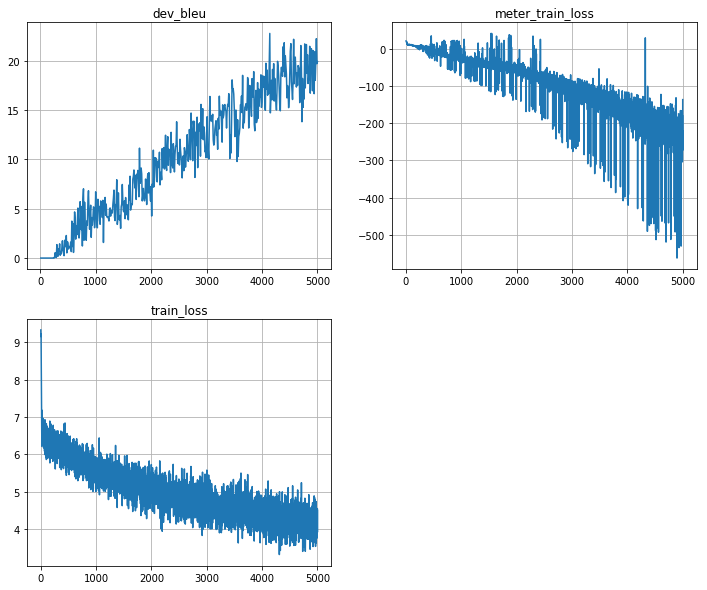

Mean loss=4.151
Execution time: 1:01:26.138286


In [36]:
train_translator_and_pentameter(
    train_inp,
    train_out,
    dev_inp,
    dev_out,
    5001)